# initial notebook for connectivity using gdal_proximity
- needs xarray-spatial, not avaliable in datacube
- can make venvs, but for below just cloned repo (https://github.com/makepath/xarray-spatial/tree/master)


In [44]:
%matplotlib inline

import sys
from osgeo import gdal
import numpy as np
import xarray as xr
import pandas as pd
import geopandas as gpd
# pd.set_option('display.max_rows', None)

sys.path.insert(0, "/home/jovyan/code/dea-notebooks/Tools")
import datacube
from dea_tools.plotting import display_map
from datacube.utils.cog import write_cog
from datacube.utils.geometry import Geometry
from dea_tools.spatial import xr_rasterize
dc = datacube.Datacube()


sys.path.insert(1, "/home/jovyan/code/xarray-spatial/xrspatial")
from proximity import proximity

# load virtual product
import importlib
from datacube.virtual import catalog_from_file
from datacube.virtual import DEFAULT_RESOLVER
catalog = catalog_from_file('../virtual_products/virtual_product_cat_wcf.yaml')

In [2]:
# add time (not a range, just repeat year input here)
time_range = ("2020", "2020")

# export as geotiff?
export = True

In [3]:
# GA coastal tiles
vector_file = '../data/geojson/ga_summary_grid_c3_coastal.geojson'
attribute_col = 'geometry'

gdf = gpd.read_file(vector_file)
mainland_grid = gdf[gdf['type'] == 'mainland']

id_list = []
for index, row in mainland_grid.iterrows():
    id_list.append(row['id'])
mainland_grid.explore()

In [6]:
gdf = mainland_grid.loc[mainland_grid['id'] == 286]

In [7]:
gdf.explore()

In [8]:
# Create the 'query' dictionary object
res = (-30, 30)

query = {
    "time": time_range,
    'resolution':res}

In [9]:
# Loop through polygons in geodataframe and add geom to queries
for index, row in gdf.iterrows():
    print(f'Feature: {index + 1}/{len(gdf)}')
    
    # Extract the feature's geometry as a datacube geometry object
    geom = Geometry(geom=row.geometry, crs=gdf.crs)
    
    # Update the query to include our geopolygon
    query.update({'geopolygon': geom})

# Extracting specific keys from dictionary (removing time to load things like item and srtm)
query_notime = {key: query[key] for key in query.keys()
       & {'resolution', 'geopolygon'}}

Feature: 286/1


In [53]:
# Load item
item_ds = dc.load(product = 'item_v2', output_crs="EPSG:3577", **query_notime)
item = item_ds.relative

# Load in mangrove cover
DEAmangrove = dc.load(product = 'ga_ls_mangrove_cover_cyear_3', output_crs="EPSG:3577", **query)

# if no mangroves within AOI, create dummy xr.dataarray
if DEAmangrove.data_vars == {}:
    mangrove = xr.DataArray(np.zeros_like(item), coords=item.coords, dims=item.dims, attrs=item.attrs)
else:
    # get output of mangrove == 1, not mangrove == 0
    mangrove = (DEAmangrove.canopy_cover_class != 255)
    
    
    
# add in saltmarsh (load like mangrove) and wofs

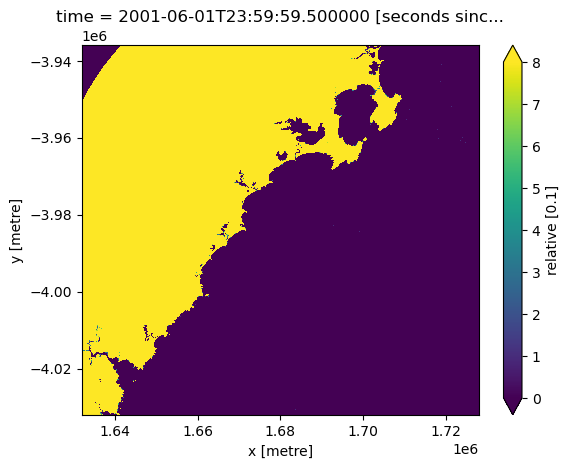

In [58]:
item.plot(vmin = 0, vmax = 8)

In [11]:
## wrangle binary maps and create STF mask

# mangrove == True


# item (remove all intertidal areas)
intertidal = item <= 8

# remove time dim
mangrove = mangrove.squeeze('time')
intertidal = intertidal.squeeze('time')

In [28]:
# combine masks
aquatic = xr.where((mangrove == False), 0, 1).astype('int8')

In [29]:
# Generate a polygon mask to keep only data within the polygon
mask = xr_rasterize(gdf, item_ds)

# Mask dataset to set pixels outside the polygon to `NaN`
aquatic = aquatic.where(mask)

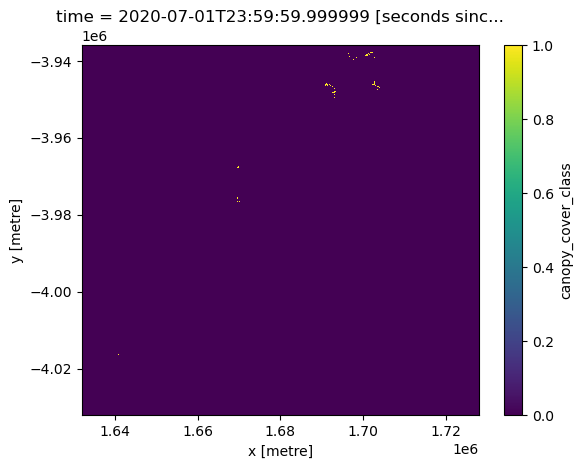

In [30]:
aquatic.plot()

In [47]:
# xrspatial proximity - https://xarray-spatial.org/reference/_autosummary/xrspatial.proximity.proximity.html
# seems it is in same units as crs (EPSG3577 = metres)
proximity_agg = proximity(aquatic)
proximity_agg

<xarray.DataArray (y: 3201, x: 3201)>
array([[48930.223 , 48907.363 , 48884.51  , ..., 25022.176 , 25052.174 ,
        25082.172 ],
       [48910.8   , 48887.934 , 48865.074 , ..., 25021.799 , 25051.797 ,
        25081.795 ],
       [48891.395 , 48868.516 , 48845.65  , ..., 25021.457 , 25051.455 ,
        25081.453 ],
       ...,
       [ 3810.4724,  3791.174 ,  3772.0154, ..., 76701.32  , 76725.16  ,
        76748.99  ],
       [ 3833.432 ,  3814.2495,  3795.2075, ..., 76719.55  , 76743.375 ,
        76767.21  ],
       [ 3856.488 ,  3837.421 ,  3818.4944, ..., 76737.78  , 76761.61  ,
        76785.43  ]], dtype=float32)
Coordinates:
    time         datetime64[ns] 2020-07-01T23:59:59.999999
  * y            (y) float64 -3.936e+06 -3.936e+06 ... -4.032e+06 -4.032e+06
  * x            (x) float64 1.632e+06 1.632e+06 ... 1.728e+06 1.728e+06
    spatial_ref  int32 3577

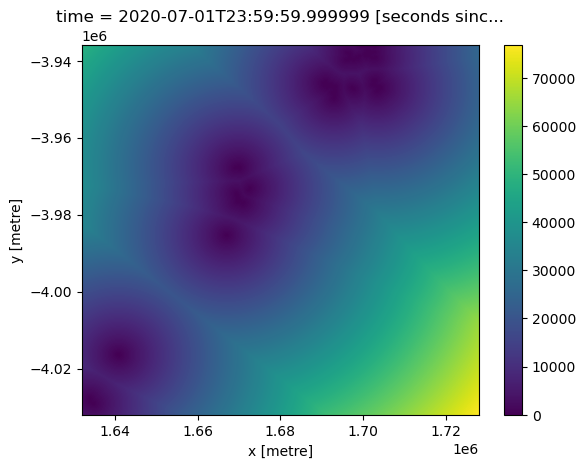

In [48]:
proximity_agg.plot()

In [50]:
# Find the minimum and maximum values in the data array
min_value = proximity_agg.min()
max_value = proximity_agg.max()

# Normalize the data to the range [0, 1] by subtracting the minimum and dividing by the range
normalized_data = (proximity_agg - min_value) / (max_value - min_value)

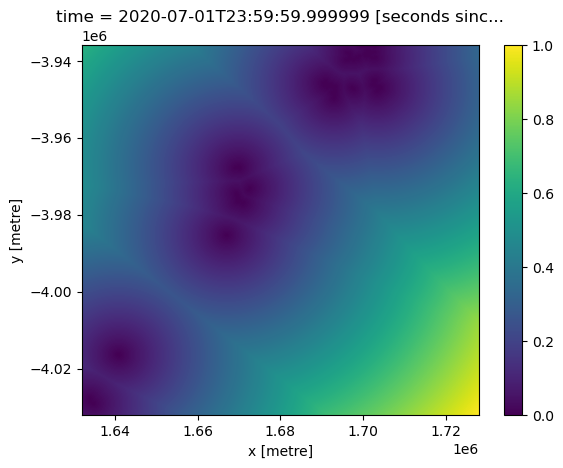

In [52]:
normalized_data.plot()